In [1]:
import pyro
import pyro.distributions as dist
import torch
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import torch.nn.functional as F
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''
M: # regions
N: # bins per region
L: # signals (signals)
alpha: params of dirichlet prior over reference epigenomics
beta: ref --> sample state categorical distribution
p: state --> signal bernoulli distribution 
r: reference state at each bin. one-hot encoding, matrix size : #bins * #ref * #states
theta: the mixture probabilities of reference ethetagenome
'''
class real_simulation:
    def __init__(self):
        self.num_bins = 10000
        self.num_signals = 5
        self.num_obs_signals = 3
        self.num_references = 15
        self.num_groups = 5
        self.num_ref_per_groups = int(self.num_references/self.num_groups)
        self.num_states = 8
        self.num_const_states = 5
        self.num_ctSpec_states = 3
        self.state_vary_rate = 0.03
        self.high_w = 10
        self.sample = None
        self.params = None #self.set_params()
        
    def generate_param_p(self):
        '''
        M1 --> 5: H3K4me3, H3K27ac, DNase, H3K4me1 (TSS like), RepressiveM
        S0: H3K4me3, constitutive
        S1: quiescent, constitutive
        S2: RepressiveM, constitutive
        S3: DNase, const
        S4: Dnase + K4me1, const
        S5: K27ac, ct-spec
        S6: K27ac + RepressiveM, ct-spec
        S7: poised TSS, K4me3 + repressiveM, ct-spec
        '''
        p = torch.zeros((self.num_states, self.num_signals)) - self.high_w
        p[0,0] = self.high_w # K4me3
        p[2,4] = self.high_w # RepressiveM
        p[3,2] = self.high_w # Dnase
        p[4,2] = self.high_w # Dnase
        p[4,3] = self.high_w # K4me1
        p[5,1] = self.high_w # K27ac
        p[6,1] = self.high_w # K27ac
        p[6,4] = self.high_w # RepressiveM
        p[7,0] = self.high_w # K4me3
        p[7,4] = self.high_w # RepressiveM
        p = torch.sigmoid(p) # each row is a probability distribution over marks, sigmoid to convert to [0,1]
        return p

    # generate a state assignment tensor
    # shape is (num_bins, num_references)
    def generate_ref_states(self):
        group_r = torch.ones(self.num_bins, self.num_groups)
        const_ratio = 0.05 * self.num_const_states # 5 constitutive states
        const_nBins = int(self.num_bins * const_ratio)
        ctSpec_ratio = 0.05 * self.num_groups * self.num_ctSpec_states # 3 ct-spec states
        ctSpec_nBins = self.num_bins - const_nBins
        # sample constitutive position
        const_bins = np.random.choice(self.num_bins, const_nBins, replace = False)
        numBins_per_state = int(0.05 * self.num_bins)
        for i in range(self.num_const_states): 
            # first num_const_states are const_states
            bins_indices = torch.tensor(const_bins[i*numBins_per_state:(i+1)*numBins_per_state]).type(torch.LongTensor)
            group_r[bins_indices,:] = i
        # sample ctSpec positions
        ctSpec_bins = torch.tensor(np.setdiff1d(np.arange(self.num_bins), const_bins)).type(torch.LongTensor)
        num_ctSpec_bins_per_group = self.num_ref_per_groups*numBins_per_state
        for i in range(self.num_groups):
            indices_for_group = np.random.choice(ctSpec_bins, num_ctSpec_bins_per_group, replace = False)
            ctSpec_bins = torch.tensor(np.setdiff1d(ctSpec_bins, indices_for_group)).type(torch.LongTensor)
            # ctSpec_bins will shrink after each iteration to assign bins to each group
            for j in range(self.num_ctSpec_states):
                # after all constitutive states have been filled, 
                # we shall fill the ctSpec states
                stateI = self.num_const_states + j
                indices_for_state = np.random.choice(indices_for_group, numBins_per_state, replace = False)
                group_r[indices_for_state, i] = stateI # ct_spec state in this group
                indices_for_group = torch.tensor(np.setdiff1d(indices_for_group, indices_for_state)).type(torch.LongTensor)
                # indices_for_group will shrink after each iteration to assign bins to state withing the group
                # quiescent state in other groups by default because of how group_r is initiated
        # now randomly introduce some noise by varying states among references of the same group, to be implemented
        # create a new dimension: num_ref_per_group --> num_ref_per_group, num_bins, num_group: --> values: state
        r = group_r.unsqueeze(0).repeat(self.num_ref_per_groups,1,1) 
        # unsqueeze(0) to add 1 dimension to the front
        # repeat to repeat along each each dimension
        return r.long() # convert to long because they will be used as index later
    
    # set parameters of the data generator
    def set_params(self):
        # parameters of the dirichlet over references
        # same one for every region
        # very high probability that generated sample looks like
        # reference 0
        # shape is (num_references,)
        alpha = torch.ones(self.num_groups)
        alpha[0] = self.high_w # we assume group 1 has the highest prob of being similar to sample of interest
        
        # parameters of bernoulli distribution for each signal
        # for each state
        # shape is (num_states, num_signals)
        p = self.generate_param_p()
        
        # an indicator matrix along genome of the state for 
        # each refenrece
        # shape is (num_ref_per_groups, num_bins, num_group, num_states)
        ref_states_indicator = F.one_hot(self.generate_ref_states(), self.num_states)
        # count of num_ref in each group that are annotated as each state
        # shape is (num_bins, num_groups, num_states)
        ref_states_count = ref_states_indicator.sum(axis = 0) 
        params = {
            'alpha': alpha,
            'p': p,
            'ref_states_indicator': ref_states_indicator,
            'ref_states_count' : ref_states_count
        }
        self.params = params
        return params
    
    # collapse a prob vector over references to a prob vector over states
    # takes the cross product of prob vector theta and reference state indicator matrix r
    # shapes:
    #  theta: (None, num_groups)
    #  r: (None, num_groups, num_states)
    #  out: (None, num_states)
    def collapse_theta(self, theta, r=None):
        if r is None:
            assert self.params is not None
            r = self.params['ref_states_count']
        r = r.float()
        collapsed_theta = torch.zeros(theta.shape[0], r.shape[2]) # bins, states
        for i in range(theta.shape[0]):
            collapsed_theta[i,:] = torch.matmul(r[i,:,:].T, theta[i,:])
        collapsed_theta = collapsed_theta / float(self.num_ref_per_groups) 
        # the above line is added for the case of state count
        # instead of state indicators
        return collapsed_theta
    
    def generate_sample(self):
        if self.params is None:
            self.set_params()
            
        r = self.params['ref_states_count']
                
        # generate reference distribution for each region
        with pyro.plate('bins', self.num_bins):
            # theta is shape (num_regions, num_references)
            theta = pyro.sample('theta', dist.Dirichlet(self.params['alpha']))
            # collapse the reference distribution for each bin to a 
            # state distribution 
            collapsed_theta = self.collapse_theta(theta, r)
        state = pyro.sample('state', dist.Categorical(collapsed_theta).to_event(1)) # 1D tensor of state indices
        signal_params = self.params['p'][state,:] # each row shows the probabilities of signals given the selected state at the genomic bin
        m = pyro.sample('m', dist.Bernoulli(signal_params).to_event(1))

        result = {
            'theta': theta,
            'state': state,
            'm': m
        }
        self.sample = result
        return self.sample
    

    def get_sampled_collapsed_theta(self):
        if self.sample is None:
            self.generate_sample()
        theta = self.sample['theta']
        return self.collapse_theta(theta)

    def save_collapsed_theta(self, output_fn):
        collapsed_theta = self.get_sampled_collapsed_theta()
        collapsed_theta = pd.DataFrame(collapsed_theta.numpy())
        collapsed_theta['state'] = self.sample['state'].numpy()
        collapsed_theta.to_csv(output_fn, header = True, index = False, sep = '\t')
        return 

    def get_sampled_signals(self):
        if self.sample is None:
            self.generate_sample()
        return self.sample['m']
    
    def get_sampled_theta(self):
        if self.sample is None:
            self.generate_sample()
        return self.sample['theta']
    
    def get_signal_parms(self):
        if self.sample is None:
            self.generate_sample()
        collapsed_theta = self.get_sampled_collapsed_theta()
        state = pyro.sample('state', dist.Categorical(collapsed_theta).to_event(1)) # 1D tensor of state indices
        signal_params = self.params['p'][state,:]
        return signal_params
    
    def get_state(self):
        if self.sample is None:
            self.generate_sample()
        return self.sample['state']
    
    def get_ref_state_indicators(self):
        if self.params is None:
            self.set_params()
        return self.params['ref_states_indicator']
    
    def get_ref_state_counts(self):
        if self.params is None:
            self.set_params()
        return self.params['ref_states_count']
    

In [3]:
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

generator = real_simulation()

raw_m = generator.get_sampled_signals()
m = raw_m[:,:3] # obs data should be only the first 3 marks
r = generator.get_ref_state_counts().float()
collapsed_theta = generator.get_sampled_collapsed_theta()
state = generator.get_state()
generator.save_collapsed_theta('trial_collapsed_theta.txt.gz')
theta = generator.get_sampled_theta()
signal_params = generator.get_signal_parms()

In [ ]:
toy = real_simulation()
r = toy.generate_ref_states()
# now let's do some testing that the function generate_ref_states is doing exactly what I want it to
# Check # of bins in constitutive
for i in range(5,8): # first 5 constitutive states
    print(i)
    num_val_per_row = torch.sum(r==i, 1)
    uniq_count = torch.unique(num_val_per_row, return_counts = True)
    print(uniq_count)
# Check # bins where the states are different across the sample (ct_spec)
# They they are different, make sure they are of the same group (3 samples, 5 samples apart)
indices = ((r==7).nonzero(as_tuple= True))
print(indices)

In [6]:
print('m: obs. signals at each position')
print(m.shape)
print(m)
print('r: reference epigenome state indicator at each position')
print(r.shape)
print(r)
print('collapsed_theta: state assignment at each position')
print(collapsed_theta.shape)
print(collapsed_theta)
print('theta: the reference mixture at each position')
print(theta.shape)
print(theta)
print('signal_params: bernoulli dist. params generating signal at each position')
print(signal_params.shape)
print('p')
raw_p = generator.params['p']
print (raw_p)
print (raw_p.shape)
p = raw_p[:,:3] # p given to model only include parameters of the observed marks

m: obs. signals at each position
torch.Size([10000, 3])
tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
r: reference epigenome state indicator at each position
torch.Size([10000, 5, 8])
tensor([[[0., 3., 0.,  ..., 0., 0., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 3.],
         [0., 3., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 3., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.]],

        [[0., 3., 0.,  ..., 0., 0., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 3.],
         [0., 3., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 3., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.],

In [ ]:
t = r[:1,:,:]
print(t)
t2 = t.reshape(t.shape[0], -1)
print(t2)

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_signals, num_states, num_groups, hidden_sig, hidden_ref, hidden_comb, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(num_signals, hidden_sig)
        self.fc2 = nn.Linear(num_states*num_groups, hidden_ref)
        self.fc_comb = nn.Linear(hidden_sig+hidden_ref, hidden_comb)
        self.fcmu = nn.Linear(hidden_comb, num_states)
        self.fclv = nn.Linear(hidden_comb, num_states)

    def forward(self, m, r):
        r = r.reshape(r.shape[0], -1) # flatten from bins,groups,states --> bins, groups*states
        h1 = F.softplus(self.fc1(m)) # hidden_sig
        h2 = F.softplus(self.fc2(r)) # hidden_ref
        h2 = self.drop(h2)
        h = torch.cat((h1, h2), 1) # concat to increase # columns # hidden_sig + hidden_ref
        h = F.softplus(self.fc_comb(h)) # hidden_comb
        logpi_loc = self.fcmu(h) # num_states
        logpi_logvar = self.fclv(h) # num_states
        logpi_scale = (0.5 * logpi_logvar).exp()
        return logpi_loc, logpi_scale

class Decoder(nn.Module):
    def __init__(self, num_states, num_signals, num_groups, hidden_sig, hidden_ref, hidden_comb, dropout, fixed_signalP):
        super().__init__()
        self.num_states = num_states
        self.num_signals = num_signals
        self.num_groups = num_groups
        self.drop = nn.Dropout(dropout)
        self.fixed_signalP = fixed_signalP
        self.fcih = nn.Linear(num_states, hidden_comb) # input (state probabilities) --> hidden
        self.fchh_sig = nn.Linear(hidden_comb, hidden_sig) # hiddent --> hidden
        self.fchs_sig = nn.Linear(hidden_sig, self.num_signals) # hidden --> signals
        self.fchh_ref = nn.Linear(hidden_comb, hidden_ref) # hidden --> hidden_ref
        self.fchr_ref = nn.Linear(hidden_ref, self.num_groups * self.num_states)


    def forward(self, inputs):
        # takes in the values of collapsed pi: probabilities of state 
        # assignments at each positions, and then apply a linear trans
        # to get the probabilities of observing signals at each position
        # --> vector size #signals
        # used as parameters for bernoulli dist. to get obs. signals
        # create multiple layers
        # inputs: bins, state probabilities
        # h: bins, hidden 
        # signal_param: bins, signals
        # ref_param: bins, num_groups, num_states
        h = F.softplus(self.fcih(inputs)) # states --> hidden element vector
        h = self.drop(h)
        signal_param = torch.sigmoid(torch.matmul(inputs, self.fixed_signalP)) # hidden_sig --> marks
        h_ref = F.softplus(self.fchh_ref(h)) # hidden_comb --> hidden_ref
        ref_param = torch.sigmoid(self.fchr_ref(h_ref))
        return signal_param, ref_param

class Model_three(nn.Module):
    def __init__(self, num_signals, num_groups, num_ref_per_groups, num_states, hidden_sig, hidden_ref, hidden_comb, dropout, fixed_signalP):
        super().__init__()
        self.num_signals = num_signals
        self.num_groups = num_groups
        self.num_ref_per_groups = num_ref_per_groups
        self.num_states = num_states
        self.hidden_sig = hidden_sig
        self.hidden_ref = hidden_ref
        self.hidden_comb = hidden_comb
        self.fixed_signalP = fixed_signalP
        self.dropout = dropout
        self.encoder = Encoder(num_signals, num_states, num_groups, hidden_sig, hidden_ref, hidden_comb, dropout)
        self.decoder = Decoder(num_states, num_signals, num_groups, hidden_sig, hidden_ref, hidden_comb, dropout, fixed_signalP)

    # shapes: 
    #  m: (bins x signals) signal matrix
    #  r: (bins x reference x state) indicator matrix
    def model(self, m, r):
        # flatten out the r indicator matrix
        pyro.module("decoder", self.decoder)
        with pyro.plate('bins', m.shape[0]):
            logCpi_loc = m.new_zeros((m.shape[0], self.num_states))
            logCpi_scale = m.new_ones((m.shape[0], self.num_states))
            logCpi = pyro.sample('log_collapsedPi', dist.Normal(logCpi_loc, logCpi_scale).to_event(1))
            Cpi = F.softmax(logCpi, -1) 
            # the softmax function should be used here because Cpi is lognormal
            signal_param, ref_param = self.decoder(Cpi) # vector of probabilities. 
            ref_param = ref_param.reshape((ref_param.shape[0], self.num_groups, self.num_states)) 
            # hidden --> num_ref*num_states
            ref_param = F.normalize(ref_param, p = 1.0, dim = 2, eps = 1e-6) # row normalize, sum over states per ref is 1
            # signal_param: bins, signals
            # ref_param: bins, references, states
            # first num_signals elements: bernoulli params
            # each of the following num_states elements: multinomial params
            # for the state segmentation in a reference    
            pyro.sample('m', dist.Bernoulli(signal_param).to_event(1), obs=m)
            # plate across references
            with pyro.plate('refs', self.num_groups):
                pyro.sample('r', dist.Multinomial(self.num_ref_per_groups, ref_param).to_event(1), obs = r)
                # multinomial for non-homogeneous total_counts are not supported yet

    def guide(self, m, r):
        pyro.module("encoder", self.encoder)
        with pyro.plate('bins', m.shape[0]):
            logpi_loc, logpi_scale = self.encoder(m, r)
            try:
                logpi = pyro.sample('log_collapsedPi', dist.Normal(logpi_loc, logpi_scale).to_event(1))
            except:
                torch.save(ref_param, 'problematic_logpi_loc.txt')
                exit(1)

    def predict_state_assignment(self, m, r):
        logpi_loc, logpi_scale = self.encoder(m, r)
        Cpi = F.softmax(logpi_loc, -1)
        return(Cpi)

    def write_predicted_state_assignment(self, m, r, output_fn):
        Cpi = self.predict_state_assignment(m, r)
        df = pd.DataFrame(Cpi.detach().numpy())
        df['max_state'] = df.idxmax(axis = 1)
        df.to_csv(output_fn, header = True, index = False, sep = '\t', compression = 'gzip')
        return

    def generate_reconstructed_data(self, m, r):
        logpi_loc, logpi_scale = self.encoder(m, r)
        Cpi = F.softmax(logpi_loc, -1)
        signal_param, ref_param = self.decoder(Cpi) # vector of probabilities. 
        ref_param = ref_param.reshape((ref_param.shape[0], self.num_groups, self.num_states)) 
        ref_param = F.normalize(ref_param, p = 1.0, dim = 2, eps = 1e-6)
        re_m = pyro.sample('re_m', dist.Bernoulli(signal_param).to_event(1))
        re_r = pyro.sample('re_r', dist.Multinomial(1, ref_param).to_event(1))
        return(re_m, re_r)


    def get_percentage_correct_reconstruct(self, m, r):
        # m and r can be different from the m and r used in training
        re_m, re_r = self.generate_reconstructed_data(m,r)
        # re_r: bins, groups, states --> counts
        total_m_entries = re_m.shape[0] * re_m.shape[1]
        signals_CR = (re_m==m).sum() # correct reconstruct entries of signals
        total_r_entries = re_r.shape[0] * self.num_groups
        # for each reference at each position, if the state assignment is different between re_r and r, there are 2 out of num_states entries that are different between re_r and r
        wrong_r = torch.abs(re_r - r)/(2.0 * self.num_ref_per_groups) # # bins and average references per group that re_r got wrong
        r_CR = total_r_entries - wrong_r.sum()
        ratio_m_CR = (signals_CR / total_m_entries).item()
        ratio_r_CR = (r_CR / total_r_entries).item()
        return ratio_m_CR, ratio_r_CR






In [7]:
batch_size = 200
learning_rate = 1e-3
num_epochs = 1000
pyro.clear_param_store()
state_model = Model_three(
    num_signals = generator.num_signals - 2,
    num_groups = generator.num_groups,
    num_ref_per_groups = generator.num_ref_per_groups,
    num_states = generator.num_states,
    hidden_sig = 1,
    hidden_ref = 20,
    hidden_comb = 21,
    dropout = 0.2, 
    fixed_signalP = p)
state_model.to(device)
optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(state_model.model, state_model.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(m.shape[0] / batch_size))

bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_m = m[i * batch_size:(i+1) * batch_size, :]
        batch_r = r[i * batch_size:(i+1) * batch_size, :, :]
        loss = svi.step(batch_m, batch_r)
        running_loss += loss / batch_m.size(0)
        
    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:17<00:00,  2.65it/s, epoch_loss=1.24e+03]


## Model with reference states and fixed beta

In [ ]:
class Encoder(nn.Module):
	def __init__(self, num_signals, num_states, num_groups, hidden, dropout):
		super().__init__()
		self.drop = nn.Dropout(dropout)
		input_dim = num_signals + num_states * num_groups
		self.fc1 = nn.Linear(input_dim, hidden)
		self.fc2 = nn.Linear(hidden, hidden)
		self.fcmu = nn.Linear(hidden, num_states)
		self.fclv = nn.Linear(hidden, num_states)

	def forward(self, m, r):
		inputs = torch.cat((m, r.reshape(r.shape[0], -1)), 1)
		h = F.softplus(self.fc1(inputs))
		h = F.softplus(self.fc2(h))
		h = self.drop(h)
		logpi_loc = (self.fcmu(h))
		logpi_logvar = self.fclv(h)
		logpi_scale = (0.5 * logpi_logvar).exp()
		return logpi_loc, logpi_scale

class Decoder(nn.Module):
	def __init__(self, num_states, num_signals, num_groups, hidden, dropout, fixed_signalP):
		super().__init__()
		self.num_states = num_states
		self.num_signals = num_signals
		self.num_groups = num_groups
		self.fixed_signalP = fixed_signalP
		self.drop = nn.Dropout(dropout)
		self.fcih = nn.Linear(num_states, hidden) # input (state probabilities) --> hidden
		self.fchh = nn.Linear(hidden, hidden) # hiddent --> hidden
		self.fchs = nn.Linear(hidden, self.num_signals) # hidden --> signals
		self.fchr = nn.Linear(hidden, self.num_groups * self.num_states) # hidden --> states in references



	def forward(self, inputs):
		# takes in the values of collapsed pi: probabilities of state 
		# assignments at each positions, and then apply a linear trans
		# to get the probabilities of observing signals at each position
		# --> vector size #signals
		# used as parameters for bernoulli dist. to get obs. signals
		# create multiple layers
		# inputs: bins, state probabilities
		# h: bins, hidden 
		# signal_param: bins, signals
		# ref_param: bins, num_groups, num_states
		h = F.softplus(self.fcih(inputs)) # --> hidden element vector
		h = F.softplus(self.fchh(h)) # --> hidden element vector
		h = self.drop(h)
		signal_param = torch.sigmoid(torch.matmul(inputs, self.fixed_signalP)) # hidden --> marks
		ref_param = torch.sigmoid(self.fchr(h)).reshape((h.shape[0], self.num_groups, self.num_states)) 
		# hidden --> num_ref*num_states
		ref_param = F.normalize(ref_param, p = 1.0, dim = 2) # row normalize, sum over states per ref is 1
		return signal_param, ref_param



    
class Model_signals_refStates_fixedBeta(nn.Module):
	def __init__(self, num_signals, num_groups, num_ref_per_groups, num_states, hidden, dropout, fixed_signalP):
		super().__init__()
		self.num_signals = num_signals
		self.num_groups = num_groups
		self.num_ref_per_groups = num_ref_per_groups
		self.num_states = num_states
		self.hidden = hidden
		self.dropout = dropout
		self.fixed_signalP = fixed_signalP
		self.encoder = Encoder(num_signals, num_states, num_groups, hidden, dropout)
		self.decoder = Decoder(num_states, num_signals, num_groups, hidden, dropout, fixed_signalP)

	# shapes: 
	#  m: (bins x signals) signal matrix
	#  r: (bins x reference x state) indicator matrix
	def model(self, m, r):
		# flatten out the r indicator matrix
		pyro.module("decoder", self.decoder)
		with pyro.plate('bins', m.shape[0]):
			logCpi_loc = m.new_zeros((m.shape[0], self.num_states))
			logCpi_scale = m.new_ones((m.shape[0], self.num_states))
			logCpi = pyro.sample('log_collapsedPi', dist.Normal(logCpi_loc, logCpi_scale).to_event(1))
			Cpi = F.softmax(logCpi, -1) 
			# the softmax function should be used here because Cpi is lognormal
			signal_param, ref_param = self.decoder(Cpi) # vector of probabilities. 
			# signal_param: bins, signals
			# ref_param: bins, references, states
			# first num_signals elements: bernoulli params
			# each of the following num_states elements: multinomial params
			# for the state segmentation in a reference 
			pyro.sample('m', dist.Bernoulli(signal_param).to_event(1), obs=m)
			# plate across references
			with pyro.plate('refs', self.num_groups):
				pyro.sample('r', dist.Multinomial(self.num_ref_per_groups, ref_param).to_event(1), obs = r)

	def guide(self, m, r):
		pyro.module("encoder", self.encoder)
		with pyro.plate('bins', m.shape[0]):
			logpi_loc, logpi_scale = self.encoder(m, r)
			logpi = pyro.sample('log_collapsedPi', dist.Normal(logpi_loc, logpi_scale).to_event(1))

	def predict_state_assignment(self, m, r):
		logpi_loc, logpi_scale = self.encoder(m, r)
		Cpi = F.softmax(logpi_loc, -1)
		return(Cpi)


	def generate_reconstructed_data(self, m, r):
		logpi_loc, logpi_scale = self.encoder(m, r)
		Cpi = F.softmax(logpi_loc, -1)
		signal_param, ref_param = self.decoder(Cpi) # vector of probabilities. 
		re_m = pyro.sample('re_m', dist.Bernoulli(signal_param).to_event(1))
		re_r = pyro.sample('re_r', dist.Multinomial(1, ref_param).to_event(1))
		return(re_m, re_r)


	def get_percentage_correct_reconstruct(self, m, r):
		# m and r can be different from the m and r used in training
		re_m, re_r = self.generate_reconstructed_data(m,r)
		total_m_entries = re_m.shape[0] * re_m.shape[1]
		signals_CR = (re_m==m).sum() # correct reconstruct entries of signals
		total_r_entries = re_r.shape[0] * self.num_groups
		# for each reference at each position, if the state assignment is different between re_r and r, there are 2 out of num_states entries that are different between re_r and r
		wrong_r = ((re_r.shape[0] * re_r.shape[1] * re_r.shape[2]) - (re_r==r).sum()) / 2 # wrong reconstruct entries of reference states
		r_CR = total_r_entries - wrong_r
		ratio_m_CR = (signals_CR / total_m_entries).item()
		ratio_r_CR = (r_CR / total_r_entries).item()
		return ratio_m_CR, ratio_r_CR





In [ ]:
batch_size = 200
learning_rate = 1e-3
num_epochs = 1000
pyro.clear_param_store()
state_model = Model_signals_refStates_fixedBeta(
    num_signals = generator.num_signals - 2,
    num_groups = generator.num_groups,
    num_ref_per_groups = generator.num_ref_per_groups,
    num_states = generator.num_states,
    hidden = 32,
    dropout = 0.2,
    fixed_signalP  = p)
state_model.to(device)
optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(state_model.model, state_model.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(m.shape[0] / batch_size))
bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_m = m[i * batch_size:(i+1) * batch_size, :]
        batch_r = r[i * batch_size:(i+1) * batch_size, :, :]
        loss = svi.step(batch_m, batch_r)
        running_loss += loss / batch_m.size(0)
        
    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))

In [8]:
ratio_m_CR, ratio_r_CR = state_model.get_percentage_correct_reconstruct(m,r)
print('ratio_m_CR: {}'.format(ratio_m_CR))
print('ratio_r_CR: {}'.format(ratio_r_CR))

ratio_m_CR: 0.45320001244544983
ratio_r_CR: 0.6280733346939087


In [13]:
Cpi = state_model.predict_state_assignment(m, r)
pred_df = pd.DataFrame(Cpi.detach().numpy())
pred_df['max_state'] = pred_df.idxmax(axis =1)
pred_df.columns = list(map(lambda x: 'pred|{}'.format(x), pred_df.columns))
collapsed_theta = generator.get_sampled_collapsed_theta()
collapsed_theta = pd.DataFrame(collapsed_theta.numpy())
collapsed_theta['max_state'] = collapsed_theta.idxmax(axis = 1)
collapsed_theta.columns = list(map(lambda x: 'true|{}'.format(x), collapsed_theta.columns))

In [14]:
df = pred_df.merge(collapsed_theta, left_index = True, right_index = True)

In [15]:
df = df[['true|max_state', 'pred|max_state']]

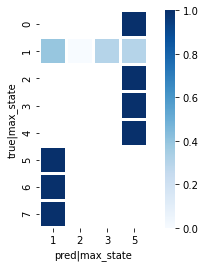

In [16]:
colnames = ['true|max_state', 'pred|max_state']
t = df[colnames]
t = t.groupby(colnames).size().to_frame(name = 'size').reset_index()
t = t.pivot(colnames[0], colnames[1], 'size')
t = t.div(t.sum(axis = 1), axis = 0) # row normalize
sns.heatmap(t, cbar=True, linewidths=2,vmax=1, vmin=0, square=True, cmap='Blues')
plt.show()

In [ ]:
print(collapsed_theta.columns)
collapsed_theta['true|max_state'].value_counts()

In [ ]:
t = torch.rand((2,3,4)) # bins, refs, states
t = F.softmax(t, -1)
t

In [ ]:
pyro.sample('r', dist.Multinomial(3, t).to_event(1))